In [24]:
import mne
import os
import re

# load data, I'm using NDARAA396TWZ and NDARAA773LUW as samples
resting_state_path = "sub-NDARAA396TWZ_task-RestingState_eeg.set"
contrast_change_path = "sub-NDARAA773LUW_task-contrastChangeDetection_run-1_eeg.set"

raw_data = []
raw_dir = os.path.join('..', '..', 'raw')
for file_name in [resting_state_path, contrast_change_path]:
    file_path = os.path.join(raw_dir, file_name)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw_data.append(raw)

resting_state, contrast_change = raw_data
resting_state_sfreq = resting_state.info['sfreq']
contrast_change_sfreq = contrast_change.info['sfreq']

In [25]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch

def segment_eeg(raw, window_sec=1.0):
    """Slice continuous EEG into fixed-length segments."""
    data = raw.get_data()  # shape (C, T_total)
    sfreq = raw.info['sfreq']
    seg_len = int(sfreq * window_sec)

    segments = []
    for start in range(0, data.shape[1] - seg_len, seg_len):
        segment = data[:, start:start+seg_len]
        segments.append(segment)
    segments = np.stack(segments)  # (N, C, T)

    # Normalize each channel within each segment
    mean = segments.mean(axis=2, keepdims=True)
    std = segments.std(axis=2, keepdims=True) + 1e-6
    segments = (segments - mean) / std
    return segments.astype(np.float32)

# Slice both datasets
resting_segments = segment_eeg(resting_state)
contrast_segments = segment_eeg(contrast_change)

# Combine and create dummy labels (0=rest, 1=task)
eeg_data = np.concatenate([resting_segments, contrast_segments], axis=0)
labels = np.concatenate([
    np.zeros((len(resting_segments), 1)),
    np.ones((len(contrast_segments), 1))
], axis=0).astype(np.float32)


In [26]:
class EEGDataset(Dataset):
    def __init__(self, eeg_data, labels):
        self.eeg_data = eeg_data
        self.labels = labels

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        x = self.eeg_data[idx]
        label = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class ImprovedEEGGenerator(nn.Module):
    def __init__(self, C, T, E, hidden=256):
        super().__init__()
        # Deeper network with residual connections
        self.initial = nn.Conv1d(C + E, hidden, kernel_size=7, padding=3)
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            self._residual_block(hidden) for _ in range(4)
        ])
        
        self.output = nn.Sequential(
            nn.Conv1d(hidden, hidden // 2, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(hidden // 2, C, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def _residual_block(self, channels):
        return nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(channels, channels, kernel_size=7, padding=3),
            nn.ReLU()
        )

    def forward(self, noise, label):
        label = label.unsqueeze(-1).expand(-1, -1, noise.size(2))
        x = torch.cat([noise, label], dim=1)
        
        x = self.initial(x)
        
        # Apply residual blocks
        for block in self.res_blocks:
            x = x + block(x)
        
        return self.output(x)


In [28]:
class ImprovedEEGDiscriminator(nn.Module):
    def __init__(self, C, T, E, hidden=256):
        super().__init__()
        # Multi-scale discriminator
        self.conv_net = nn.Sequential(
            nn.Conv1d(C + E, hidden, kernel_size=7, padding=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv1d(hidden, hidden, kernel_size=7, padding=3, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv1d(hidden, hidden * 2, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv1d(hidden * 2, hidden * 2, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        
        # Calculate flattened size after convolutions
        # T -> T/2 (first stride) -> T/4 (second stride)
        flattened_size = (hidden * 2) * (T // 4)
        
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, label):
        label = label.unsqueeze(-1).expand(-1, -1, x.size(2))
        x = torch.cat([x, label], dim=1)
        x = self.conv_net(x)
        x = x.flatten(1)
        return self.fc(x)

In [29]:
def train_gan_improved(dataloader, G, D, G_opt, D_opt, epochs=100, device='cpu'):
    """
    Improved training loop with:
    - Label smoothing
    - Gradient penalty
    - Learning rate scheduling
    - More discriminator updates
    """
    criterion = nn.BCELoss()
    scheduler_G = optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.5)
    scheduler_D = optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.5)
    
    # Label smoothing
    real_label_smooth = 0.9
    fake_label_smooth = 0.1
    
    for epoch in range(epochs):
        G_losses, D_losses = [], []
        
        for real_x, labels in dataloader:
            real_x, labels = real_x.to(device), labels.to(device)
            batch_size, C, T = real_x.shape

            # Generate random noise
            noise = torch.randn(batch_size, C, T, device=device)

            # Label smoothing
            real_y = torch.full((batch_size, 1), real_label_smooth, device=device)
            fake_y = torch.full((batch_size, 1), fake_label_smooth, device=device)

            # ---- Train Discriminator (multiple times) ----
            for _ in range(2):  # Train D more than G
                D_opt.zero_grad()

                fake_x = G(noise, labels).detach()
                real_out = D(real_x, labels)
                fake_out = D(fake_x, labels)

                D_loss = (criterion(real_out, real_y) + criterion(fake_out, fake_y)) / 2
                D_loss.backward()
                D_opt.step()

            # ---- Train Generator ----
            G_opt.zero_grad()
            
            # Use fresh noise
            noise = torch.randn(batch_size, C, T, device=device)
            fake_x = G(noise, labels)
            fake_out = D(fake_x, labels)

            # Generator wants D to output 1 (real)
            G_loss = criterion(fake_out, torch.ones(batch_size, 1, device=device))
            G_loss.backward()
            G_opt.step()
            
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())

        # Update learning rates
        scheduler_G.step()
        scheduler_D.step()
        
        avg_G_loss = sum(G_losses) / len(G_losses)
        avg_D_loss = sum(D_losses) / len(D_losses)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {avg_D_loss:.4f} | G_loss: {avg_G_loss:.4f}")


In [30]:
class SpectralLossGAN(nn.Module):
    """Alternative: Add spectral loss to encourage realistic frequency content"""
    def __init__(self):
        super().__init__()
        
    def forward(self, real_x, fake_x):
        # Compute FFT
        real_fft = torch.fft.rfft(real_x, dim=-1)
        fake_fft = torch.fft.rfft(fake_x, dim=-1)
        
        # Compare magnitude spectra
        real_mag = torch.abs(real_fft)
        fake_mag = torch.abs(fake_fft)
        
        return torch.mean((real_mag - fake_mag) ** 2)


def train_gan_with_spectral_loss(dataloader, G, D, G_opt, D_opt, epochs=100, device='cpu', lambda_spectral=0.1):
    """Training with additional spectral loss"""
    criterion = nn.BCELoss()
    spectral_loss_fn = SpectralLossGAN()
    
    for epoch in range(epochs):
        for real_x, labels in dataloader:
            real_x, labels = real_x.to(device), labels.to(device)
            batch_size, C, T = real_x.shape

            noise = torch.randn(batch_size, C, T, device=device)
            real_y = torch.ones(batch_size, 1, device=device) * 0.9
            fake_y = torch.ones(batch_size, 1, device=device) * 0.1

            # ---- Train Discriminator ----
            D_opt.zero_grad()
            fake_x = G(noise, labels).detach()
            real_out = D(real_x, labels)
            fake_out = D(fake_x, labels)
            D_loss = (criterion(real_out, real_y) + criterion(fake_out, fake_y)) / 2
            D_loss.backward()
            D_opt.step()

            # ---- Train Generator with Spectral Loss ----
            G_opt.zero_grad()
            noise = torch.randn(batch_size, C, T, device=device)
            fake_x = G(noise, labels)
            fake_out = D(fake_x, labels)

            # Adversarial loss
            G_loss_adv = criterion(fake_out, torch.ones(batch_size, 1, device=device))
            
            # Spectral loss
            G_loss_spectral = spectral_loss_fn(real_x, fake_x)
            
            # Combined loss
            G_loss = G_loss_adv + lambda_spectral * G_loss_spectral
            
            G_loss.backward()
            G_opt.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {D_loss.item():.4f} | "
                  f"G_loss: {G_loss.item():.4f} (adv: {G_loss_adv.item():.4f}, spec: {G_loss_spectral.item():.4f})")

In [31]:
C = eeg_data.shape[1]  # Number of channels
T = eeg_data.shape[2]  # Time points per segment
E = 1  # Number of label embeddings

dataset = EEGDataset(eeg_data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = ImprovedEEGGenerator(C, T, E, hidden=256).to(device)
D = ImprovedEEGDiscriminator(C, T, E, hidden=256).to(device)
G_opt = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_opt = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_gan_with_spectral_loss(dataloader, G, D, G_opt, D_opt, epochs=100, device=device)

Epoch [10/100] | D_loss: 0.3262 | G_loss: 40.3397 (adv: 2.3450, spec: 379.9465)
Epoch [20/100] | D_loss: 0.3265 | G_loss: 40.0687 (adv: 2.2034, spec: 378.6526)
Epoch [30/100] | D_loss: 0.3271 | G_loss: 37.5098 (adv: 2.2632, spec: 352.4664)
Epoch [40/100] | D_loss: 0.3265 | G_loss: 37.8397 (adv: 2.3098, spec: 355.2984)
Epoch [50/100] | D_loss: 0.3261 | G_loss: 37.7349 (adv: 2.2879, spec: 354.4697)
Epoch [60/100] | D_loss: 0.3271 | G_loss: 38.5015 (adv: 2.2498, spec: 362.5170)
Epoch [70/100] | D_loss: 0.3274 | G_loss: 37.0619 (adv: 2.4346, spec: 346.2727)
Epoch [80/100] | D_loss: 0.3261 | G_loss: 37.5493 (adv: 2.2547, spec: 352.9456)
Epoch [90/100] | D_loss: 0.3263 | G_loss: 37.7466 (adv: 2.2857, spec: 354.6089)
Epoch [100/100] | D_loss: 0.3259 | G_loss: 38.1804 (adv: 2.2568, spec: 359.2361)


Generating 100 samples...

EEG GENERATION QUALITY ASSESSMENT - REST

1. AMPLITUDE STATISTICS
----------------------------------------
Mean - Real: 0.0000, Gen: -0.0065, Error: 65267684.39%
Std  - Real: 0.9532, Gen: 0.5196, Error: 45.48%
Score: 0.0/100

2. DISTRIBUTION SIMILARITY
----------------------------------------
KS Test - Statistic: 0.1573, p-value: 0.0000
Wasserstein Distance: 0.3325
Score: 84.3/100

3. FREQUENCY CONTENT ANALYSIS
----------------------------------------
Delta  ( 0.5- 4Hz) - Real: 2.76e-01, Gen: 1.59e-01, Error: 42.27%
Theta  ( 4.0- 8Hz) - Real: 8.74e-03, Gen: 1.25e-02, Error: 43.35%
Alpha  ( 8.0-13Hz) - Real: 3.43e-03, Gen: 5.59e-03, Error: 62.97%
Beta   (13.0-30Hz) - Real: 7.56e-02, Gen: 2.17e-02, Error: 71.25%
Gamma  (30.0-50Hz) - Real: 1.46e-01, Gen: 1.95e-02, Error: 86.64%
Score: 38.7/100

4. TEMPORAL STRUCTURE
----------------------------------------
Autocorrelation MAE: nan
Score: 0.0/100

5. SPATIAL (CHANNEL) STRUCTURE
-----------------------------------

C:\Users\JINQI\AppData\Local\Temp\ipykernel_18808\1899596106.py:125: RuntimeWarning: invalid value encountered in divide
  ac = ac / ac[0]
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\JINQI\AppData\Local\Temp\ipykernel_18808\1899596106.py:314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


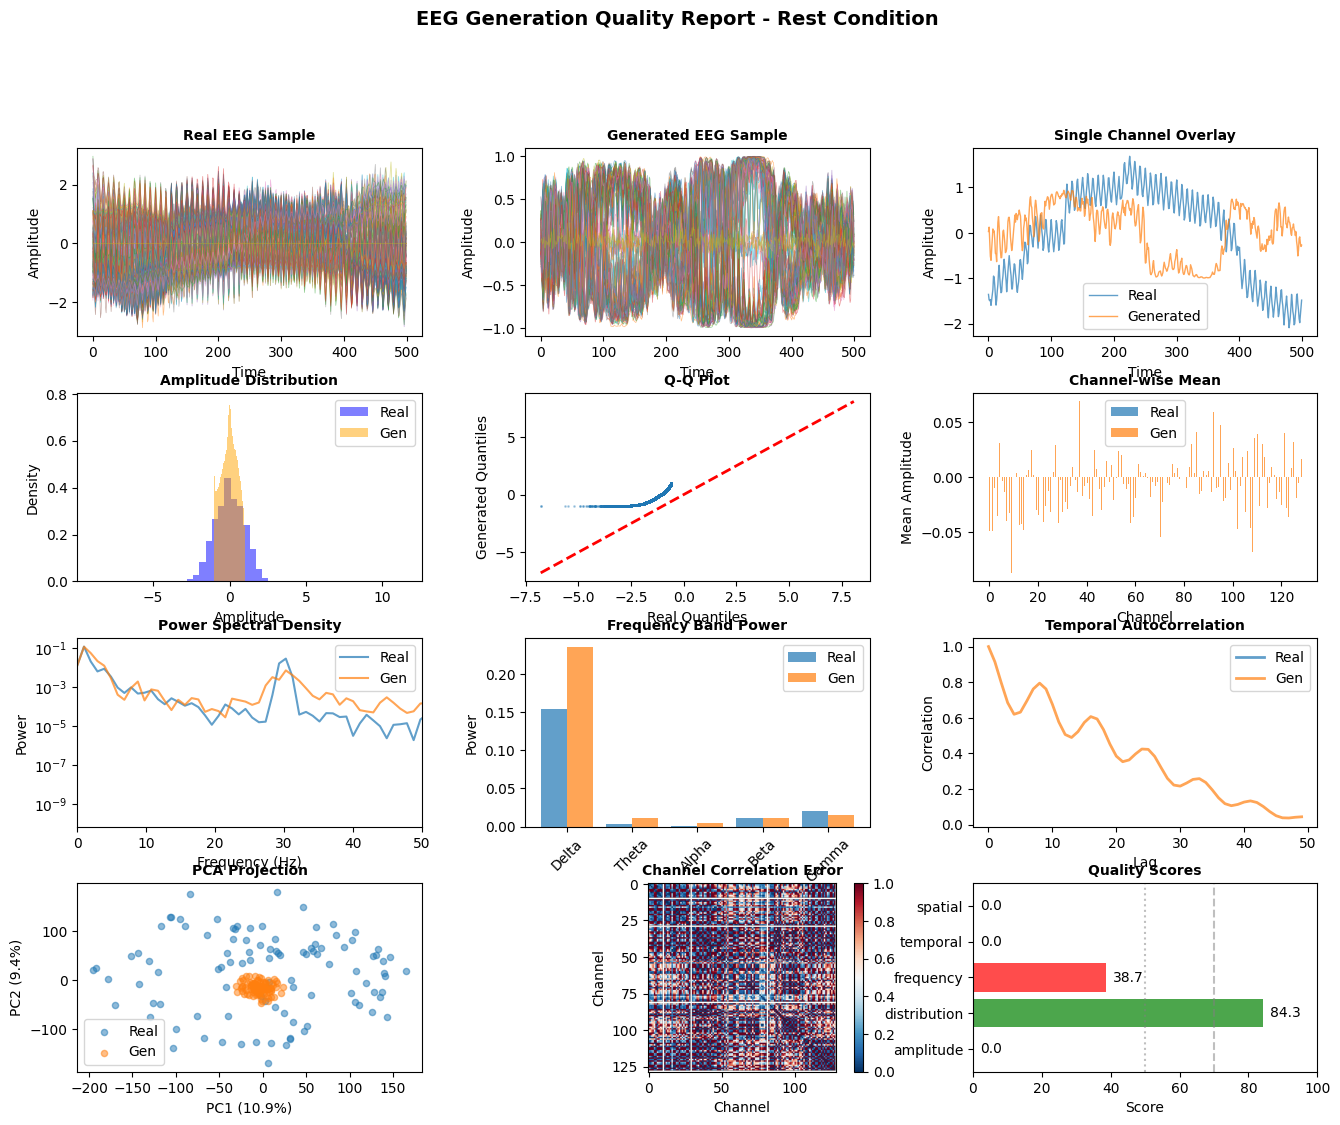


OVERALL QUALITY ASSESSMENT

Individual Scores:
  Amplitude      :   0.0/100  ✗ Poor
  Distribution   :  84.3/100  ✓ Good
  Frequency      :  38.7/100  ✗ Poor
  Temporal       :   0.0/100  ✗ Poor
  Spatial        :   0.0/100  ✗ Poor

Overall Quality Score: 24.6/100
Assessment: VERY POOR - Generated EEG unrealistic



In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def compute_eeg_quality_metrics(real_data, generated_data, labels, condition='rest', fs=250):
    """
    Comprehensive quality metrics for generated EEG
    Returns a quality score and detailed breakdown
    
    Parameters:
    - real_data: array (N, C, T) - real EEG
    - generated_data: array (M, C, T) - generated EEG  
    - labels: array (N,) - 0=rest, 1=task
    - condition: 'rest' or 'task'
    - fs: sampling rate in Hz
    """
    
    # Filter by condition
    condition_idx = 0 if condition == 'rest' else 1
    real = real_data[labels == condition_idx]
    gen = generated_data
    
    print(f"\n{'='*60}")
    print(f"EEG GENERATION QUALITY ASSESSMENT - {condition.upper()}")
    print(f"{'='*60}\n")
    
    scores = {}
    
    # ========== 1. AMPLITUDE STATISTICS ==========
    print("1. AMPLITUDE STATISTICS")
    print("-" * 40)
    
    real_mean = real.mean()
    gen_mean = gen.mean()
    real_std = real.std()
    gen_std = gen.std()
    
    mean_error = abs(real_mean - gen_mean) / (abs(real_mean) + 1e-8)
    std_error = abs(real_std - gen_std) / real_std
    
    print(f"Mean - Real: {real_mean:.4f}, Gen: {gen_mean:.4f}, Error: {mean_error:.2%}")
    print(f"Std  - Real: {real_std:.4f}, Gen: {gen_std:.4f}, Error: {std_error:.2%}")
    
    # Score: lower error = higher score
    scores['amplitude'] = max(0, 100 - (mean_error + std_error) * 50)
    print(f"Score: {scores['amplitude']:.1f}/100")
    
    # ========== 2. DISTRIBUTION SIMILARITY ==========
    print(f"\n2. DISTRIBUTION SIMILARITY")
    print("-" * 40)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pval = stats.ks_2samp(real.flatten(), gen.flatten())
    print(f"KS Test - Statistic: {ks_stat:.4f}, p-value: {ks_pval:.4f}")
    
    # Wasserstein distance (Earth Mover's Distance)
    emd = stats.wasserstein_distance(real.flatten(), gen.flatten())
    print(f"Wasserstein Distance: {emd:.4f}")
    
    # Score: similar distributions get high scores
    scores['distribution'] = max(0, 100 * (1 - ks_stat))
    print(f"Score: {scores['distribution']:.1f}/100")
    
    # ========== 3. FREQUENCY CONTENT (CRITICAL FOR EEG) ==========
    print(f"\n3. FREQUENCY CONTENT ANALYSIS")
    print("-" * 40)
    
    freq_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 50)
    }
    
    band_errors = []
    
    for band_name, (low, high) in freq_bands.items():
        # Compute band power for real
        real_powers = []
        for sample in real[:50]:  # Sample to save time
            for ch in sample:
                f, psd = signal.welch(ch, fs=fs, nperseg=min(256, len(ch)))
                band_idx = (f >= low) & (f <= high)
                real_powers.append(psd[band_idx].sum())
        
        # Compute band power for generated
        gen_powers = []
        for sample in gen[:50]:
            for ch in sample:
                f, psd = signal.welch(ch, fs=fs, nperseg=min(256, len(ch)))
                band_idx = (f >= low) & (f <= high)
                gen_powers.append(psd[band_idx].sum())
        
        real_mean_power = np.mean(real_powers)
        gen_mean_power = np.mean(gen_powers)
        
        error = abs(real_mean_power - gen_mean_power) / (real_mean_power + 1e-8)
        band_errors.append(error)
        
        print(f"{band_name:6s} ({low:4.1f}-{high:2.0f}Hz) - "
              f"Real: {real_mean_power:.2e}, Gen: {gen_mean_power:.2e}, "
              f"Error: {error:.2%}")
    
    avg_freq_error = np.mean(band_errors)
    scores['frequency'] = max(0, 100 - avg_freq_error * 100)
    print(f"Score: {scores['frequency']:.1f}/100")
    
    # ========== 4. TEMPORAL STRUCTURE ==========
    print(f"\n4. TEMPORAL STRUCTURE")
    print("-" * 40)
    
    # Autocorrelation analysis
    max_lag = 50
    real_autocorrs = []
    gen_autocorrs = []
    
    for sample in real[:20]:
        for ch in sample:
            ac = np.correlate(ch, ch, mode='full')
            ac = ac[len(ac)//2:len(ac)//2 + max_lag]
            ac = ac / ac[0]
            real_autocorrs.append(ac)
    
    for sample in gen[:20]:
        for ch in sample:
            ac = np.correlate(ch, ch, mode='full')
            ac = ac[len(ac)//2:len(ac)//2 + max_lag]
            ac = ac / ac[0]
            gen_autocorrs.append(ac)
    
    real_ac_mean = np.mean(real_autocorrs, axis=0)
    gen_ac_mean = np.mean(gen_autocorrs, axis=0)
    
    ac_error = np.mean(np.abs(real_ac_mean - gen_ac_mean))
    print(f"Autocorrelation MAE: {ac_error:.4f}")
    
    scores['temporal'] = max(0, 100 - ac_error * 100)
    print(f"Score: {scores['temporal']:.1f}/100")
    
    # ========== 5. CHANNEL CORRELATIONS ==========
    print(f"\n5. SPATIAL (CHANNEL) STRUCTURE")
    print("-" * 40)
    
    # Compute correlation matrix between channels
    real_corr = np.corrcoef(real.mean(axis=0))  # Average across samples
    gen_corr = np.corrcoef(gen.mean(axis=0))
    
    corr_error = np.mean(np.abs(real_corr - gen_corr))
    print(f"Channel Correlation MAE: {corr_error:.4f}")
    
    scores['spatial'] = max(0, 100 - corr_error * 100)
    print(f"Score: {scores['spatial']:.1f}/100")
    
    # ========== 6. VISUAL COMPARISON ==========
    print(f"\n6. GENERATING VISUAL COMPARISON...")
    print("-" * 40)
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # Row 1: Sample traces
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(real[0].T, alpha=0.5, linewidth=0.5)
    ax1.set_title('Real EEG Sample', fontsize=10, fontweight='bold')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(gen[0].T, alpha=0.5, linewidth=0.5)
    ax2.set_title('Generated EEG Sample', fontsize=10, fontweight='bold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Amplitude')
    
    # Overlay comparison
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(real[0, 0], alpha=0.7, label='Real', linewidth=1)
    ax3.plot(gen[0, 0], alpha=0.7, label='Generated', linewidth=1)
    ax3.set_title('Single Channel Overlay', fontsize=10, fontweight='bold')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Amplitude')
    ax3.legend()
    
    # Row 2: Distributions
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(real.flatten(), bins=50, alpha=0.5, label='Real', density=True, color='blue')
    ax4.hist(gen.flatten(), bins=50, alpha=0.5, label='Gen', density=True, color='orange')
    ax4.set_title('Amplitude Distribution', fontsize=10, fontweight='bold')
    ax4.set_xlabel('Amplitude')
    ax4.set_ylabel('Density')
    ax4.legend()
    
    # Q-Q plot
    ax5 = fig.add_subplot(gs[1, 1])
    real_sorted = np.sort(real.flatten()[::100])  # Subsample for speed
    gen_sorted = np.sort(gen.flatten()[::100])
    min_len = min(len(real_sorted), len(gen_sorted))
    ax5.scatter(real_sorted[:min_len], gen_sorted[:min_len], alpha=0.3, s=1)
    ax5.plot([real_sorted.min(), real_sorted.max()], 
             [real_sorted.min(), real_sorted.max()], 'r--', linewidth=2)
    ax5.set_title('Q-Q Plot', fontsize=10, fontweight='bold')
    ax5.set_xlabel('Real Quantiles')
    ax5.set_ylabel('Generated Quantiles')
    
    # Channel means comparison
    ax6 = fig.add_subplot(gs[1, 2])
    real_ch_mean = real.mean(axis=(0, 2))
    gen_ch_mean = gen.mean(axis=(0, 2))
    x = np.arange(len(real_ch_mean))
    ax6.bar(x - 0.2, real_ch_mean, 0.4, label='Real', alpha=0.7)
    ax6.bar(x + 0.2, gen_ch_mean, 0.4, label='Gen', alpha=0.7)
    ax6.set_title('Channel-wise Mean', fontsize=10, fontweight='bold')
    ax6.set_xlabel('Channel')
    ax6.set_ylabel('Mean Amplitude')
    ax6.legend()
    
    # Row 3: Frequency analysis
    ax7 = fig.add_subplot(gs[2, 0])
    # Compute average PSD
    f_real, psd_real = signal.welch(real[0, 0], fs=fs)
    f_gen, psd_gen = signal.welch(gen[0, 0], fs=fs)
    ax7.semilogy(f_real, psd_real, label='Real', alpha=0.7)
    ax7.semilogy(f_gen, psd_gen, label='Gen', alpha=0.7)
    ax7.set_xlim([0, 50])
    ax7.set_title('Power Spectral Density', fontsize=10, fontweight='bold')
    ax7.set_xlabel('Frequency (Hz)')
    ax7.set_ylabel('Power')
    ax7.legend()
    
    # Band power comparison
    ax8 = fig.add_subplot(gs[2, 1])
    band_names = list(freq_bands.keys())
    real_band_powers = []
    gen_band_powers = []
    
    for low, high in freq_bands.values():
        real_bp = []
        gen_bp = []
        for sample in real[:10]:
            f, psd = signal.welch(sample[0], fs=fs)
            band_idx = (f >= low) & (f <= high)
            real_bp.append(psd[band_idx].sum())
        for sample in gen[:10]:
            f, psd = signal.welch(sample[0], fs=fs)
            band_idx = (f >= low) & (f <= high)
            gen_bp.append(psd[band_idx].sum())
        real_band_powers.append(np.mean(real_bp))
        gen_band_powers.append(np.mean(gen_bp))
    
    x = np.arange(len(band_names))
    ax8.bar(x - 0.2, real_band_powers, 0.4, label='Real', alpha=0.7)
    ax8.bar(x + 0.2, gen_band_powers, 0.4, label='Gen', alpha=0.7)
    ax8.set_xticks(x)
    ax8.set_xticklabels(band_names, rotation=45)
    ax8.set_title('Frequency Band Power', fontsize=10, fontweight='bold')
    ax8.set_ylabel('Power')
    ax8.legend()
    
    # Autocorrelation
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.plot(real_ac_mean, label='Real', alpha=0.7, linewidth=2)
    ax9.plot(gen_ac_mean, label='Gen', alpha=0.7, linewidth=2)
    ax9.set_title('Temporal Autocorrelation', fontsize=10, fontweight='bold')
    ax9.set_xlabel('Lag')
    ax9.set_ylabel('Correlation')
    ax9.legend()
    
    # Row 4: Advanced metrics
    # PCA visualization
    ax10 = fig.add_subplot(gs[3, 0])
    real_flat = real[:100].reshape(len(real[:100]), -1)
    gen_flat = gen[:100].reshape(len(gen[:100]), -1)
    combined = np.vstack([real_flat, gen_flat])
    pca = PCA(n_components=2)
    combined_pca = pca.fit_transform(combined)
    ax10.scatter(combined_pca[:len(real_flat), 0], combined_pca[:len(real_flat), 1], 
                alpha=0.5, label='Real', s=20)
    ax10.scatter(combined_pca[len(real_flat):, 0], combined_pca[len(real_flat):, 1], 
                alpha=0.5, label='Gen', s=20)
    ax10.set_title('PCA Projection', fontsize=10, fontweight='bold')
    ax10.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax10.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax10.legend()
    
    # Channel correlation heatmap
    ax11 = fig.add_subplot(gs[3, 1])
    im = ax11.imshow(np.abs(real_corr - gen_corr), cmap='RdBu_r', vmin=0, vmax=1)
    ax11.set_title('Channel Correlation Error', fontsize=10, fontweight='bold')
    ax11.set_xlabel('Channel')
    ax11.set_ylabel('Channel')
    plt.colorbar(im, ax=ax11, fraction=0.046)
    
    # Overall scores
    ax12 = fig.add_subplot(gs[3, 2])
    categories = list(scores.keys())
    values = list(scores.values())
    colors = ['green' if v >= 70 else 'orange' if v >= 50 else 'red' for v in values]
    bars = ax12.barh(categories, values, color=colors, alpha=0.7)
    ax12.set_xlim([0, 100])
    ax12.set_xlabel('Score')
    ax12.set_title('Quality Scores', fontsize=10, fontweight='bold')
    ax12.axvline(70, color='gray', linestyle='--', alpha=0.5, label='Good')
    ax12.axvline(50, color='gray', linestyle=':', alpha=0.5, label='Fair')
    
    # Add score values on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax12.text(val + 2, i, f'{val:.1f}', va='center')
    
    plt.suptitle(f'EEG Generation Quality Report - {condition.capitalize()} Condition', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # ========== OVERALL QUALITY SCORE ==========
    print(f"\n{'='*60}")
    print("OVERALL QUALITY ASSESSMENT")
    print(f"{'='*60}")
    
    overall_score = np.mean(list(scores.values()))
    
    print(f"\nIndividual Scores:")
    for metric, score in scores.items():
        status = "✓ Good" if score >= 70 else "⚠ Fair" if score >= 50 else "✗ Poor"
        print(f"  {metric.capitalize():15s}: {score:5.1f}/100  {status}")
    
    print(f"\nOverall Quality Score: {overall_score:.1f}/100")
    
    if overall_score >= 80:
        quality = "EXCELLENT - Generated EEG closely matches real data"
    elif overall_score >= 70:
        quality = "GOOD - Generated EEG is realistic"
    elif overall_score >= 60:
        quality = "FAIR - Some discrepancies but usable"
    elif overall_score >= 50:
        quality = "POOR - Significant differences from real data"
    else:
        quality = "VERY POOR - Generated EEG unrealistic"
    
    print(f"Assessment: {quality}")
    print(f"{'='*60}\n")
    
    return overall_score, scores


# ========== USAGE ==========
def evaluate_gan_quality(G, real_data, labels, device, C, T, n_samples=100, condition='rest'):
    """
    Complete evaluation pipeline
    """
    # Generate samples
    print(f"Generating {n_samples} samples...")
    G.eval()
    generated_samples = []
    
    condition_label = 0.0 if condition == 'rest' else 1.0
    
    with torch.no_grad():
        for i in range(n_samples):
            label = torch.tensor([[condition_label]], device=device)
            noise = torch.randn(1, C, T, device=device)
            fake_eeg = G(noise, label).cpu().numpy()[0]
            generated_samples.append(fake_eeg)
    
    generated_data = np.array(generated_samples)
    
    # Run quality assessment
    overall_score, scores = compute_eeg_quality_metrics(
        real_data, generated_data, labels, condition=condition, fs=250
    )
    
    return overall_score, scores


# Before running the evaluation, flatten your labels
labels = labels.flatten()  # or labels = labels.squeeze()

# Then run
score, metrics = evaluate_gan_quality(G, eeg_data, labels, device, C, T, n_samples=100, condition='rest')